![Сбор данных](https://ptzgovorit.ru/sites/default/files/original_nodes/banka_tasima_7.jpg)

# Содержание

- [1. Библиотеки](#1.-Импорт-библиотек-и-загрузка-данных-для-моделирования)
- [2. Моделирования ARIMA](#2.-Моделирования-ARIMA)
- [3. Моделирование алгоритмами ML](#3.-Моделирование-алгоритмами-ML)
- [4. Моделирование алгоритмами ML с сэмплами](#4.-Моделирование-алгоритмами-ML-с-сэмплами)
- [5. Моделирование алгоритмами ML с выделением признаков из сэмплов](#5.-Моделирование-алгоритмами-ML-с-выделением-признаков-из-сэмплов)

# 1. Импорт библиотек и загрузка данных для моделирования

In [104]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import random

#импортируем модели-регрессоры для использовнаия их в функциях прогнозирования
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [105]:
#загрузим собственную бибдиотеку sberlib, в которой находятся классы и функции с прогнозными моделями
#для этого загрзим модуль, импортирующий файлы-ьлокноты (import_ipynb)
import import_ipynb
import sberlib

#из нашей библиотеки sberlib загрузим классы для построения прогнозов по модели ARIMA с первой разностью
from sberlib import OptimizedARIMA, ARIMA

In [106]:
#в датафреймы загрузим два рядя данных: (1) resampled с сжатыми данными до шага в один месяц;
#(2) notsampled с исходным посуточным рядом и колонками res (первые разности) и value_filt (фильтрованные данные)
data = pd.read_csv('~/Sber/data_resampled.csv', sep = ';')
sb = pd.read_csv('~/Sber/data_notsampled.csv', sep = ';')

In [107]:
#данные в колонке date датафрейма sb преобразуем в формат datetime
sb['date'] = pd.to_datetime(sb['date'], format = '%Y-%m-%d')

In [108]:
#посмотрим на данные
data, sb

(          date    value    value_filt      res
 0   2013-12-31   3417.1   3451.526706    -40.5
 1   2014-01-31   3282.8   3399.004007    916.5
 2   2014-02-28   3885.9   3875.036610    677.1
 3   2014-03-31   4699.4   4740.814001   1239.5
 4   2014-04-30   4270.6   3544.483327  10578.3
 ..         ...      ...           ...      ...
 66  2019-06-30  61914.9  62341.010574   2115.0
 67  2019-07-31  62498.2  62343.468930   -732.6
 68  2019-08-31  59314.6  59449.450436  -2139.1
 69  2019-09-30  58806.3  59834.636322    159.2
 70  2019-10-31  61596.1  61451.675523  10990.5
 
 [71 rows x 4 columns],
            date    value     res    value_filt
 0    2013-12-30   3457.6     NaN   3457.612614
 1    2013-12-31   3417.1   -40.5   3451.526706
 2    2014-01-01   3417.1     0.0   3446.605409
 3    2014-01-02   3417.1     0.0   3443.885054
 4    2014-01-03   3417.1     0.0   3444.156062
 ...         ...      ...     ...           ...
 2106 2019-10-06  64630.1     0.0  66844.954790
 2107 2019-10-

[Вверх к содержанию](#Содержание)

# 2. Моделирования ARIMA

В этом разделе построим прогноз на основе модели ARIMA.

Для этого необходимо создать экземпляр класса OptimizedARIMA(start_date, month_number, data). В качестве аргументов необходимо указать следующее:
> - start_date: стартовая дата, с котрой строится прогноз; необходимо указать дату в фромате год-месяц-день; день необходимо указывать последней датой месяца, так как в этой модели используется resampled ряд с сжатыми данными до шага в один месяц;
> - month_number: количество месяцев (длину горизонта прогнозирования), на которое строится прогноз;
> - data: это датафрейм, данные из котрого будут использоваться для прогноза, в этом разделе используем data, так как там помесячные resampled данные о ежемесячных минимумах остатков на счетах.

Прогноз строится на данных до стартовой даты. Сам прогноз затем на графике сравнивается с фактическими данными. В качестве оценки качества прогноза используются две величины:
> - Среднемесячное (на горизонте прогнозирования) отклонение от фактических остатков в процентах от остатков;
> - Максимум пробития (максимальное превышение прогнозом фактических месячных минимумов).

Для построения прогноза необходимо использовать метод forecast_plot(), применяемый к экземпляру класса OptimizedARIMA. Результатом выполнения метода является построение ежемесячого графика прогноза остатоков в сравнении с фактом, оценки ошибок, а также для информации приводятся оптимальные (для которых ошибки прогноза минимальны) средняя скорость роста остатков и стандартное отклонение от тренда роста остатков, которые используются в случайном члене модели ARIMA.

Необходимо правильно выбирать стартовую дату и горизонт прогнозирования (они не должны выходить за рамки горизонта исходной базы данных)

**Ниже приведен пример построение прогноза со стартовой датой start_date='2018-12-31', 8-ми месячным горизонтом и исходными данными data**

Среднемесячное отклонение от фактических остатков: 5.5 %
Максимум пробития млн. руб.: 6998.0
Оптимальная средняя скорость роста остатков: 1367.3 млн. руб./мес.
Оптимальное стандартное отклонение остатков: 979.7 млн. руб.


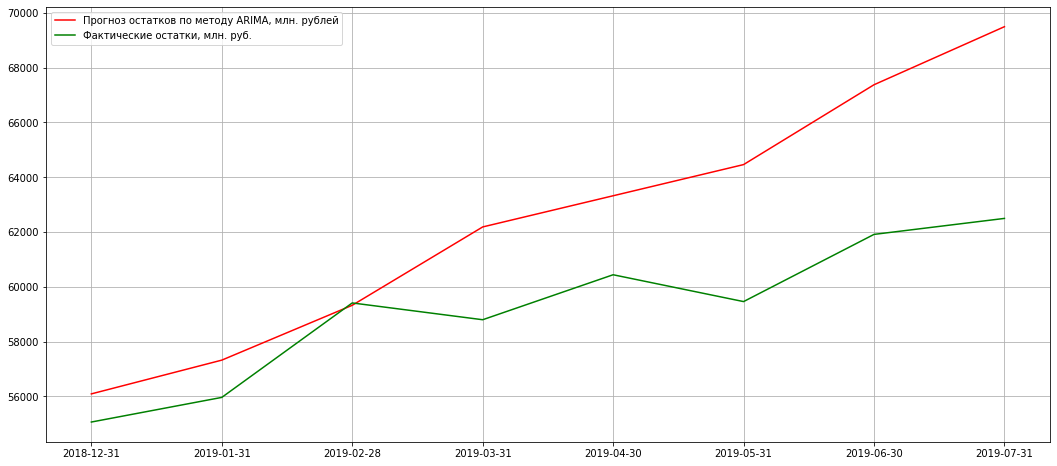

In [109]:
#создаем экземпляр класса OptimizedARIMA с указанной стартовой датой, горизонтом прогноза 8 месяцев и входными данными data
Sber_forecast = OptimizedARIMA(start_date='2018-12-31', month_number=8, data=data)

#строим прогноз для экземпляра
Sber_forecast.forecast_plot()

Модель разработана для прогноза месячных остатков. Однако может построить и посуточный прогноз. Для построения посуточного прогноза необходимо в качестве базы данных загрузить не data, а sb, а в качестве горизонта прогнозирования month_number указать не количество месяцев, а количество суток. Как пример ниже приводится результат посуточного прогнозирования моделью ARIMA на горизонте 60 дней (2 месяца)

Среднемесячное отклонение от фактических остатков: 6.9 %
Максимум пробития млн. руб.: 9316.9
Оптимальная средняя скорость роста остатков: 97.9 млн. руб./мес.
Оптимальное стандартное отклонение остатков: 781.1 млн. руб.


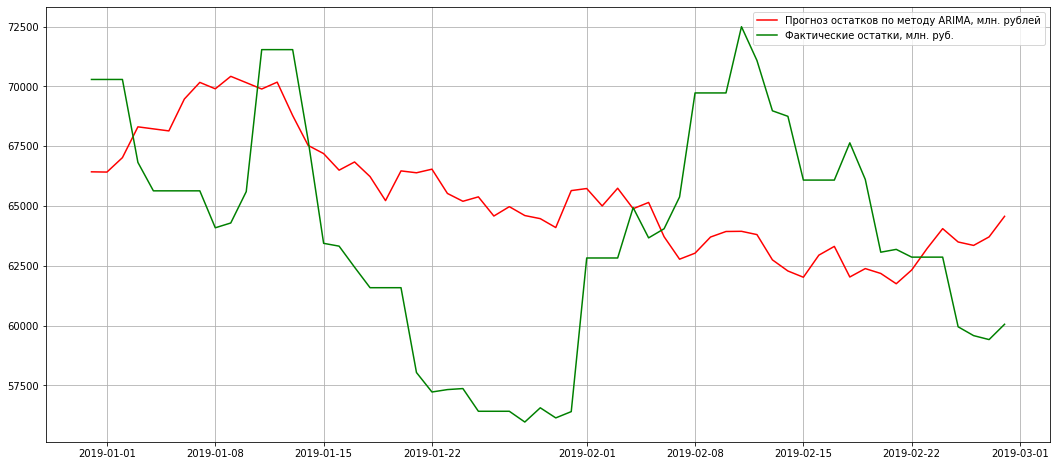

In [102]:
#создаем экземпляр класса OptimizedARIMA с указанной стартовой датой, горизонтом прогноза 120 дней и входными данными sb
Sber_forecast_daily = OptimizedARIMA(start_date='2018-12-31', month_number=60, data=sb)

#строим прогноз для экземпляра
Sber_forecast_daily.forecast_plot()

Для оценки модели на разных периодах прогнозирования построим цикл моделирований с различными стартовыми датами и горизонтом прогнозирования 10 месяцев (горизонт можно менять в пределах от 1 до 12 месяцев). Для каждой стартовой даты выведем ошибки прогнозирования.

Для вывода ошибок прогноза необходимо использовать метод forecast_errors() для экземпляра класса OptimizedARIMA

In [103]:
start_date = '2015-11-30' #первая стартовая дата в цикле прогнозов
finish_date = '2018-11-30' #финальная дата для старта последнего 10-ти месячного прогноза

for date in data[(data.date >= start_date) &
                 (data.date <= finish_date)].date.values:
    Sber_forecast_cycle = OptimizedARIMA(start_date=str(date)[:10], month_number=10, data=data) #создание модели для каждой стартовой даты в цикле
    print(str(date)[:10]) #печатаем стартовую даты очередного прогноза в цикле
    Sber_forecast_cycle.forecast_errors() #выводим ошибки прогноза для этой стартовой даты (10-ти месячный прогноз)

2015-11-30
Среднемесячное отклонение от фактических остатков: 8.9 %
Максимум пробития млн. руб.: 1024.8
2015-12-31
Среднемесячное отклонение от фактических остатков: 8.8 %
Максимум пробития млн. руб.: 2203.9
2016-01-31
Среднемесячное отклонение от фактических остатков: 10.2 %
Максимум пробития млн. руб.: 1127.0
2016-02-29
Среднемесячное отклонение от фактических остатков: 13.3 %
Максимум пробития млн. руб.: 880.3
2016-03-31
Среднемесячное отклонение от фактических остатков: 16.2 %
Максимум пробития млн. руб.: 937.0
2016-04-30
Среднемесячное отклонение от фактических остатков: 18.6 %
Максимум пробития млн. руб.: 57.8
2016-05-31
Среднемесячное отклонение от фактических остатков: 18.0 %
Максимум пробития млн. руб.: 493.0
2016-06-30
Среднемесячное отклонение от фактических остатков: 9.0 %
Максимум пробития млн. руб.: 614.3
2016-07-31
Среднемесячное отклонение от фактических остатков: 6.8 %
Максимум пробития млн. руб.: 1680.6
2016-08-31
Среднемесячное отклонение от фактических остатков: 13.

Выводы:
> - анализ ошибок прогнозировнаия с разными стартовыми датами показывает, что ARIMA неплохо прогнозирует на временном ряде с устоявшимся трендом;
> - при смене трендом средней скорости роста и стандартного отклонения ARIMA начинает ухудшать прогноз, ей необходимо время для адаптации к новому тренду.

[Вверх к содержанию](#Содержание)

# 3. Моделирование алгоритмами ML

В этом разделе для прогнозирования применим простой подход моделирования с использованием моделей машинного обучения. Разделим временной ряд на две части: (1) временной ряд до стартовой даты start_date, от которой строится прогноз;(2) временной ряд после стартовой даты до даты прогнозирования forecast_date.

На первой части ряда тренируется модель Regressor (модель можно менять), далее строится прогноз на вторую часть и сравнивается на графике с фактом, а также подсчитываются ошибки и выводятся на экран.

Для построения прогноза необходимо из библиотеки sberlib использовать функцию:
ML_forecast(start_date, forecast_date, data, model)

В качестве аргументов функции необходимо поставить стартовую и финальную даты горизонта прогнозирования в формате YYYY-MM-DD, а также указать какими данными вы будете пользоваться (sb, с посуточными данными или data, с месячными сжатыми данными), в конце указать модель Regressor, которую хотите использовать (LinearRegression, Ridge, RandomForest или иную). Внутри модели можно дополнительно указывать параметры регрессора.

Среднемесячное отклонение от фактических остатков: 7.37 %
Максимум пробития млн. руб.: 1756.0 млн. руб.


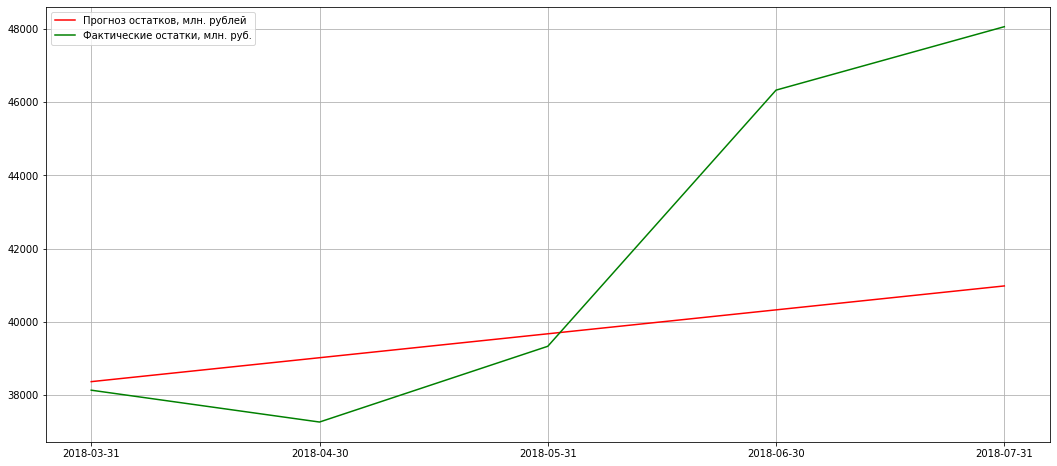

In [110]:
%run sberlib.ipynb #команда, необходимая для запуска функции из библиотеки sberlib

#пример моделирования с моделью Ridge() на ежемесячных resampled данных
ML_forecast(start_date='2018-03-31', forecast_date='2018-08-31', data=data, model=Ridge(alpha=200))

Выводы:
> - в целом точность прогноза по такой модели похуже, чем у ARIMA и также, например в 2017 году, плохо прогнозирует в периоды смены характеристик тренда;
> - однако смена модели и подбор гиперпараметров модели часто позволяет улучшить точность. Например, Ridge(alpha=200) неплоход прогнозировала в период с марта по август 2018 года, однако гораздо хуже, если период сдвинуть на год: март - август 2019. Но смена Ridge на XGBRegressor дает значительное улучшение точности для этого периода.

[Вверх к содержанию](#Содержание)

# 4. Моделирование алгоритмами ML с сэмплами

В этом разделе усложним процесс обучения модели. Ту часть временного ряда (value) остатков, которая ограничивается прошлым (до start_date) будем делить на сэмплы. Сэмпл - это отрезки временного ряда определенного размера по времени, которые сдвинуты друг относительно друга на одни сутки (для данных в sb) или один месяц (для данных в data). Размер сэмпла может варьироваться и составлять от 2 до 365 суток (для данных в sb) или от 5 до 50 месяцев (для данных в data).

Сэмплы складываются в матрицу признаков, в которой строки - это сэмплы, а целевая переменная - значение ряда, отстоящее от сэмпла на заданную горизонтом прогнозирования величину.

Матрица признаков (размера количество_сэмплов Х размер сэмпла) и столбец целевых значений являются входом для модели машинного обучения (модели можно применять разные). Обученную модель применяем к сэмплу, который находится непосредственно перед start_date, что даст нам прогноз на сэмпл, сразу после start_date и сравниваем этот прогнозный сэмпл на графике с фактом, а также считаем ошибки.

Размер сэмплов сильно влияет на точность моделирования на разных горизонтах. По этой причине в функции моделирования предусмотрен цикл выбора оптимального по ошибке прогнозирования размера сэмпла.

Размер оптимального сэмпла (в сутках или месяцах в зависимости от выбранной базы данных) выводится на экран вместе с ошибками прогнозирования и графиком прогноза.

Для прогноза необходимо использовать функцию ML_forecast_optimized_samples(start_date, forecast_date,
                    data,
                    model,
                    min_sample_size,
                    max_sample_size)

В качестве аргументов необходимо указать начальную и конечную дату горизонта прогнозирования, источник данных, модель машинного обучения, включая ее параметры, минимальный и максимальный размеры сэмплов, в диапазоне которых будет выбран оптимальный размер сэмпла.

**Пример прогнозирования с суточыми данными, моделью регрессии случайным лесом и максимальным размером сэмплов 360 суток)**

Оптимальный размер сэмпла: 342
Среднемесячное отклонение от фактических остатков: 4.86 %
Максимум пробития млн. руб.: 3125.0 млн. руб.


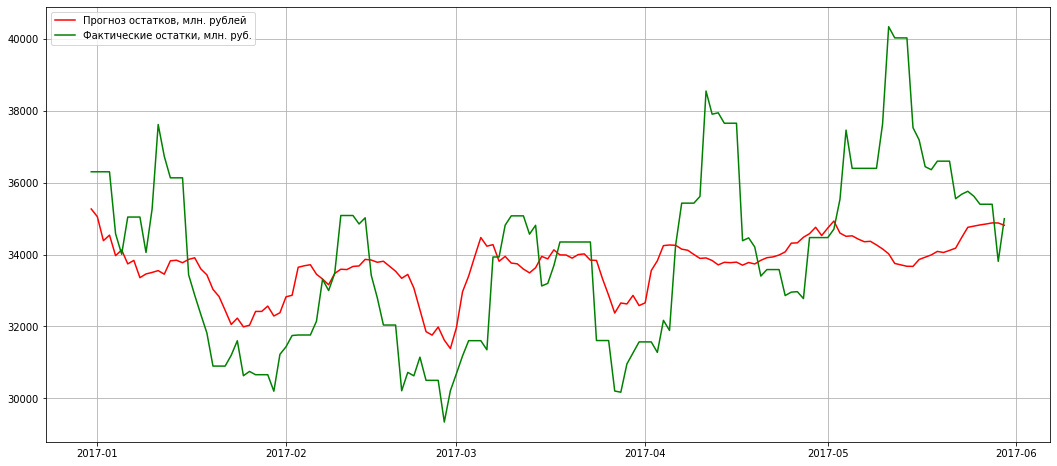

In [68]:
ML_forecast_optimized_samples(start_date='2016-12-31', forecast_date='2017-05-31',
                    data=sb,
                    model=RandomForestRegressor(random_state=42, n_jobs=-1),
                    min_sample_size=20,
                    max_sample_size =360)

**Пример прогнозирования с суточными данными моделью регрессии K-ближайших соседей и максимальным размером сэмплов 360 суток)** 

Оптимальный размер сэмпла: 60
Среднемесячное отклонение от фактических остатков: 5.75 %
Максимум пробития млн. руб.: 3753.0 млн. руб.


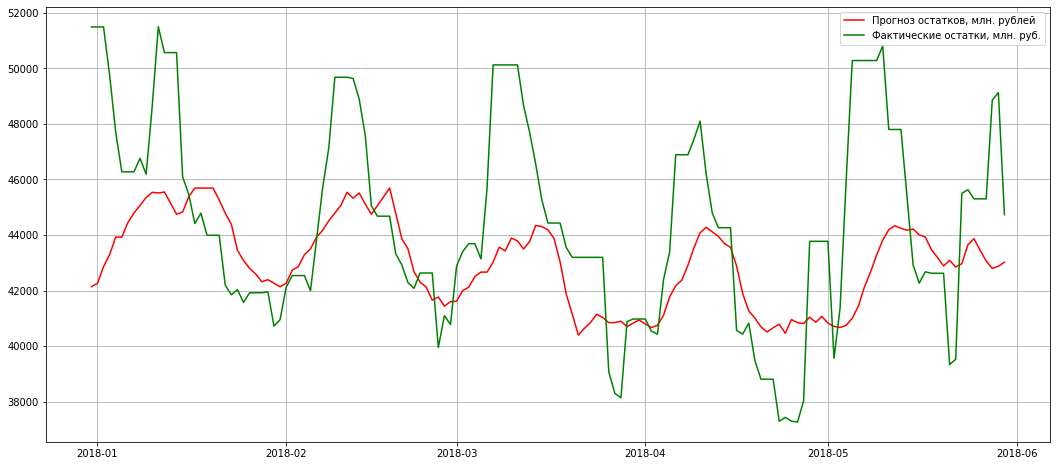

In [111]:
ML_forecast_optimized_samples(start_date='2017-12-31', forecast_date='2018-05-31',
                    data=sb,
                    model=KNeighborsRegressor(n_neighbors=20),
                    min_sample_size=25,
                    max_sample_size =360)

**Пример прогнозирования с ежемесячными данными, моделью линейной регрессии и максимальным размером сэмплов 35 месяцев)**

Оптимальный размер сэмпла: 35
Среднемесячное отклонение от фактических остатков: 6.78 %
Максимум пробития млн. руб.: 0.0 млн. руб.


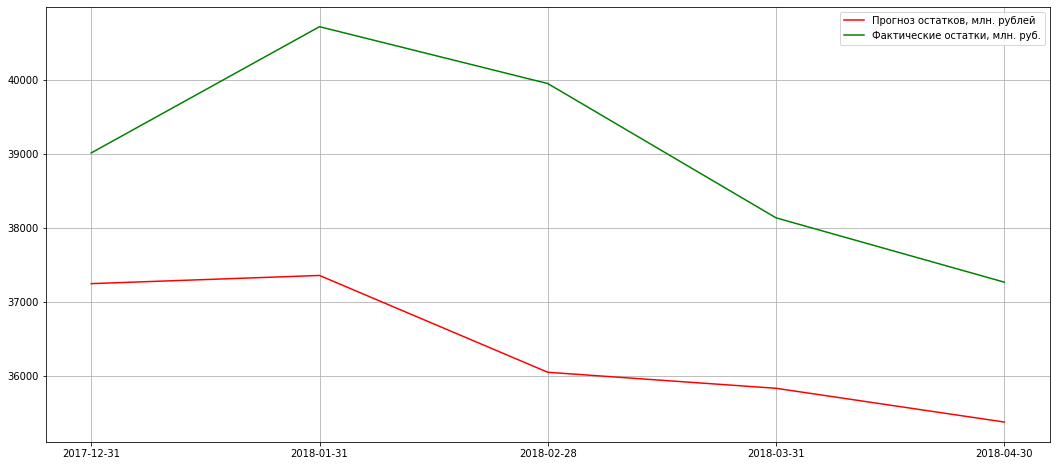

In [112]:
%run sberlib.ipynb
ML_forecast_optimized_samples(start_date='2017-12-31', forecast_date='2018-05-31',
                              data=data,
                              model=LinearRegression(),
                              max_sample_size =35)

Выводы:
> - в целом точность прогноза по такой модели получше, чем у ARIMA;
> - однако необходимо на разных горизонтах подбирать разные модели регрессоров (чаще лучшие результаты показывает линейная регрессия), а также экспериментировать с гиперпараметрами. С одной стороны это усложняет моделирование, но с другой стороны дает большую гибкость и большие возможности для повышение точности прогнозов, чем у ARIMA.

[Вверх к содержанию](#Содержание)

# 5. Моделирование алгоритмами ML с выделением признаков из сэмплов

В этой части моделирование также строится на сэмплах. Однако вместо самих значений ряда в качестве признаков берутся харктеристики сэмпла (среднее, макисмум, минимум и другие признаки, весь перечень можно увидеть в библиотеке sberlib в функции ML_forecast_features).

Ниже приводятся два примера: один с суточными данными; второй с месячными данными.

В целом точность прогнозирования примерно такая же, как у ARIMA.

Из библиотеки sberlib необходимо брать функцию ML_forecast_optimized_features для построения прогноза. Выод данных аналогичен предыдущему методу с сэмплами.

Оптимальный размер сэмпла: 42
Среднемесячное отклонение от фактических остатков: 6.61 %
Максимум пробития млн. руб.: 5032.0 млн. руб.


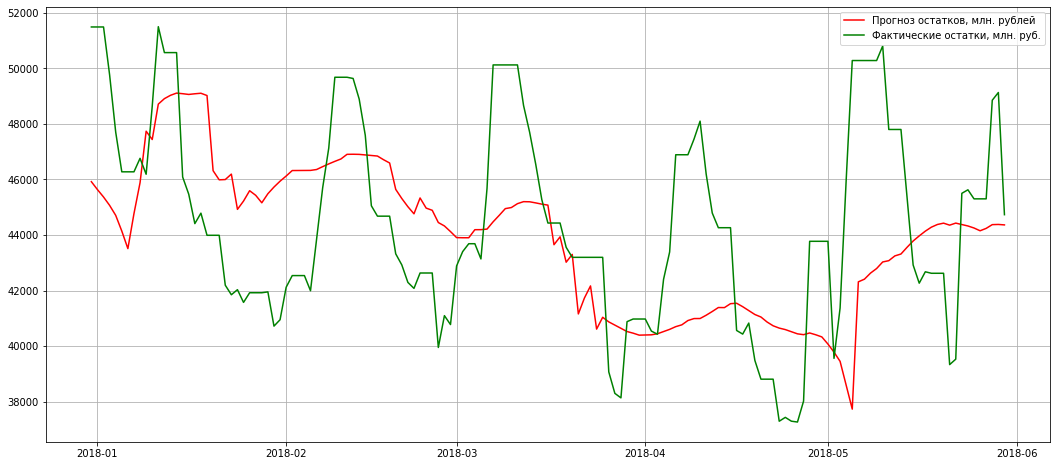

In [113]:
%run sberlib.ipynb
ML_forecast_optimized_features(start_date='2017-12-31', forecast_date='2018-05-31',
                    data=sb,
                    model=LinearRegression(),
                    min_sample_size=5,
                    max_sample_size =365)

Оптимальный размер сэмпла: 27
Среднемесячное отклонение от фактических остатков: 1.91 %
Максимум пробития млн. руб.: 0.0 млн. руб.


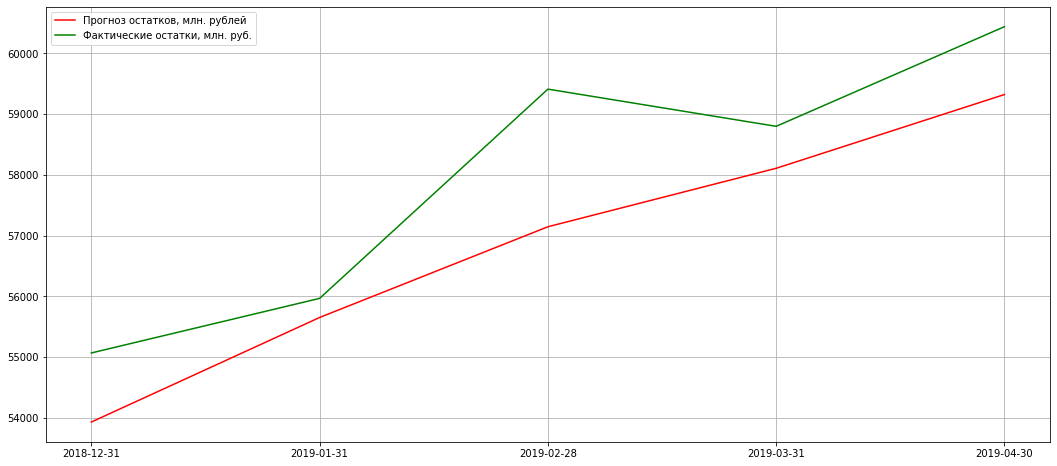

In [114]:
%run sberlib.ipynb
ML_forecast_optimized_features(start_date='2018-12-31', forecast_date='2019-05-31',
                    data=data,
                    model=LinearRegression(),
                    min_sample_size = 5,
                    max_sample_size =35)

[Вверх к содержанию](#Содержание)